<a href="https://colab.research.google.com/github/ritwiks9635/My_priject_file_5/blob/main/Lung_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dataset == https://www.kaggle.com/datasets/ andrewmvd/lung-and-colon-cancer-histopathological-images

In [ ]:
from zipfile import ZipFile
data = "/content/https:/www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/lung-and-colon-cancer-histopathological-images.zip"
with ZipFile(data,"r") as zip:
  zip.extractall()
  print("the data has been extracted ")

the data has been extracted 


IMPORT MODULE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = "/content/lung_colon_image_set/lung_image_sets"
classes = os.listdir(path)
classes

['lung_n', 'lung_scc', 'lung_aca']

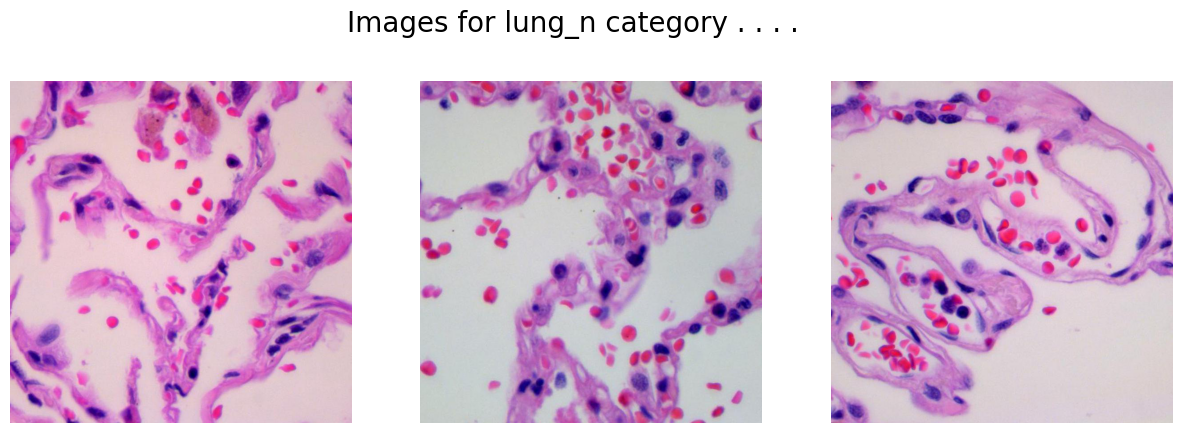

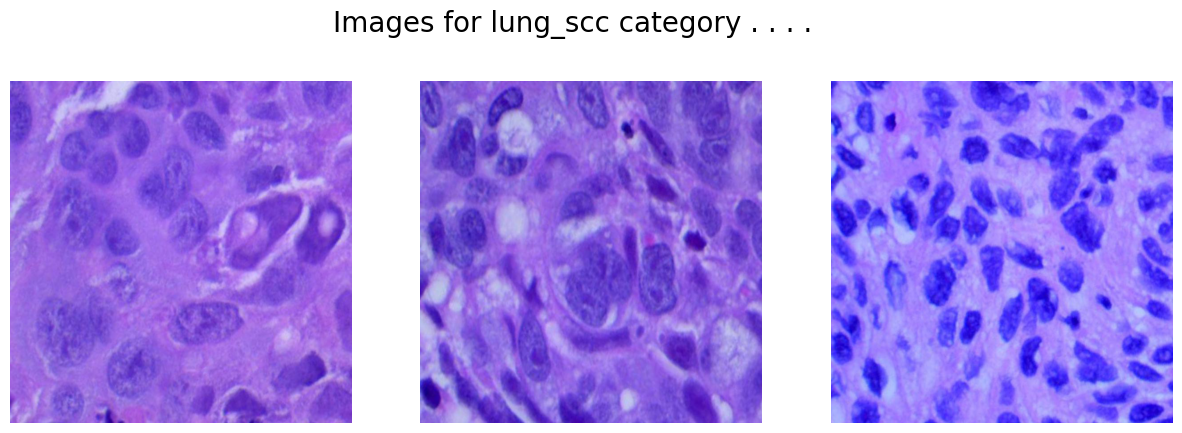

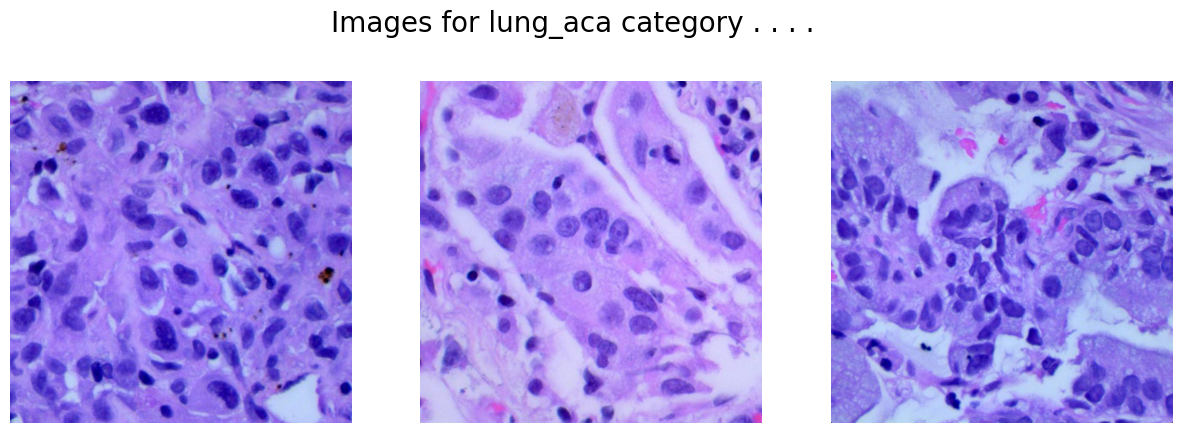

In [ ]:
for cls in classes:
  img_dir = f"{path}/{cls}"
  images = os.listdir(img_dir)
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(f'Images for {cls} category . . . .', fontsize=20)
  for i in range(3):
    k = np.random.randint(0, len(images))
    img = np.array(Image.open(f'{path}/{cls}/{images[k]}'))
    ax[i].imshow(img)
    ax[i].axis('off')
  plt.show()

Data Preparation for Training

In [ ]:
#Some of the hyperparameters which we can tweak from here for the whole notebook.

In [ ]:
img_size = 256
split = 0.2
epochs = 10
batch_size = 64

In [ ]:
#One hot encoding will help us to train
#a model which can predict soft probabilities
#of an image being from each class with the
#highest probability for the class to which
#it really belongs.

In [ ]:
X = []
Y = []
for i, cls in enumerate(classes):
  images = glob(f"{path}/{cls}/*.jpeg")
  for img in images:
    imgs = cv2.imread(img)

    X.append(cv2.resize(imgs, (img_size, img_size)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [ ]:
# Split the dataset using train_test_split

In [ ]:
X_train, x_val, y_train, y_val = train_test_split(X, one_hot_encoded_Y, test_size=split, random_state = 2023)
print(X_train.shape, x_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [ ]:
# Model development

In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(img_size,
                               img_size,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [ ]:
# model summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

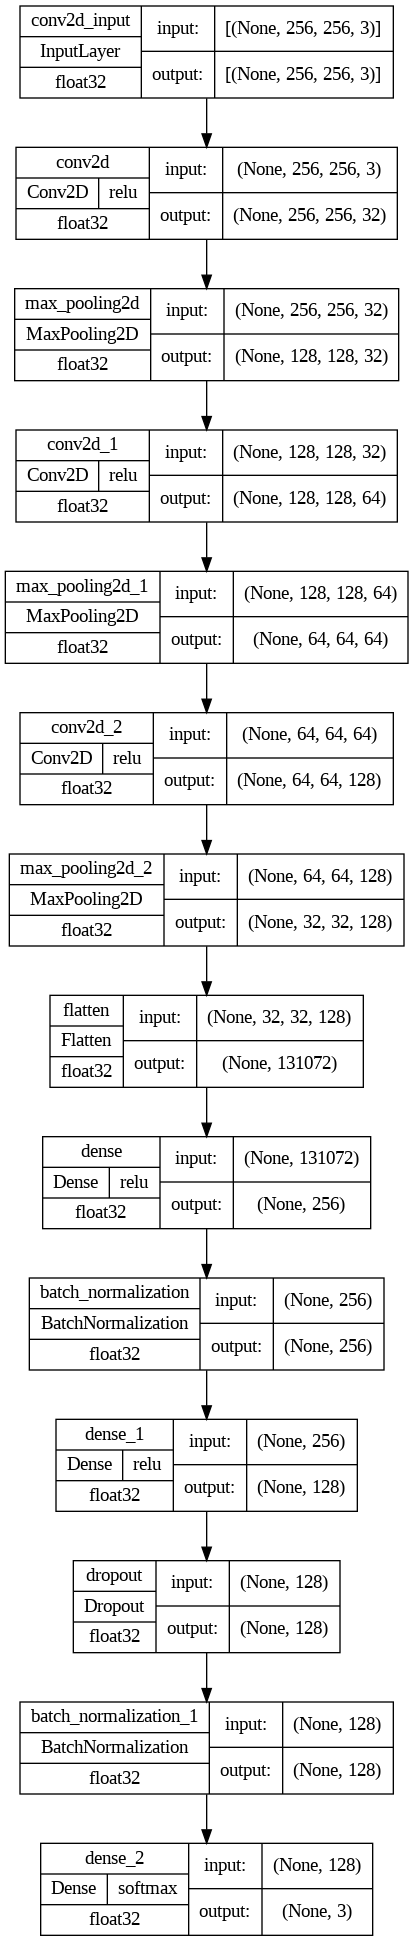

In [ ]:
# plot model architecture 
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
# Compiling the model
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
# Callbacks are used to check whether the model is improving with each epoch or not.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True

#if model performance is not improving then training will be stopped by EarlyStopping.
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
#ReduceLROnPlateau decreases learning rate further
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

Training the model

In [ ]:

history = model.fit(X_train, y_train,
                    validation_data = (x_val, y_val),
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

visualize the training and validation accuracy with each epoch.

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

Model Evaluation

In [ ]:
Y_pred = model.predict(x_val)
Y_val = np.argmax(y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
#Let’s draw the confusion metrics and classification report using the predicted labels and the true labels.
metrics.confusion_matrix(Y_val, Y_pred)

In [ ]:

print(metrics.classification_report(Y_val, Y_pred,target_names=classes))